In [1]:
# VOTING REGRESSOR MODEL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
train_data = pd.read_excel(r"./../train_dataset_kaggle.xlsx")
pd.set_option('display.max_columns', None)
print(train_data.head())
print(train_data.info())
print(train_data["Duration"].value_counts())

       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64


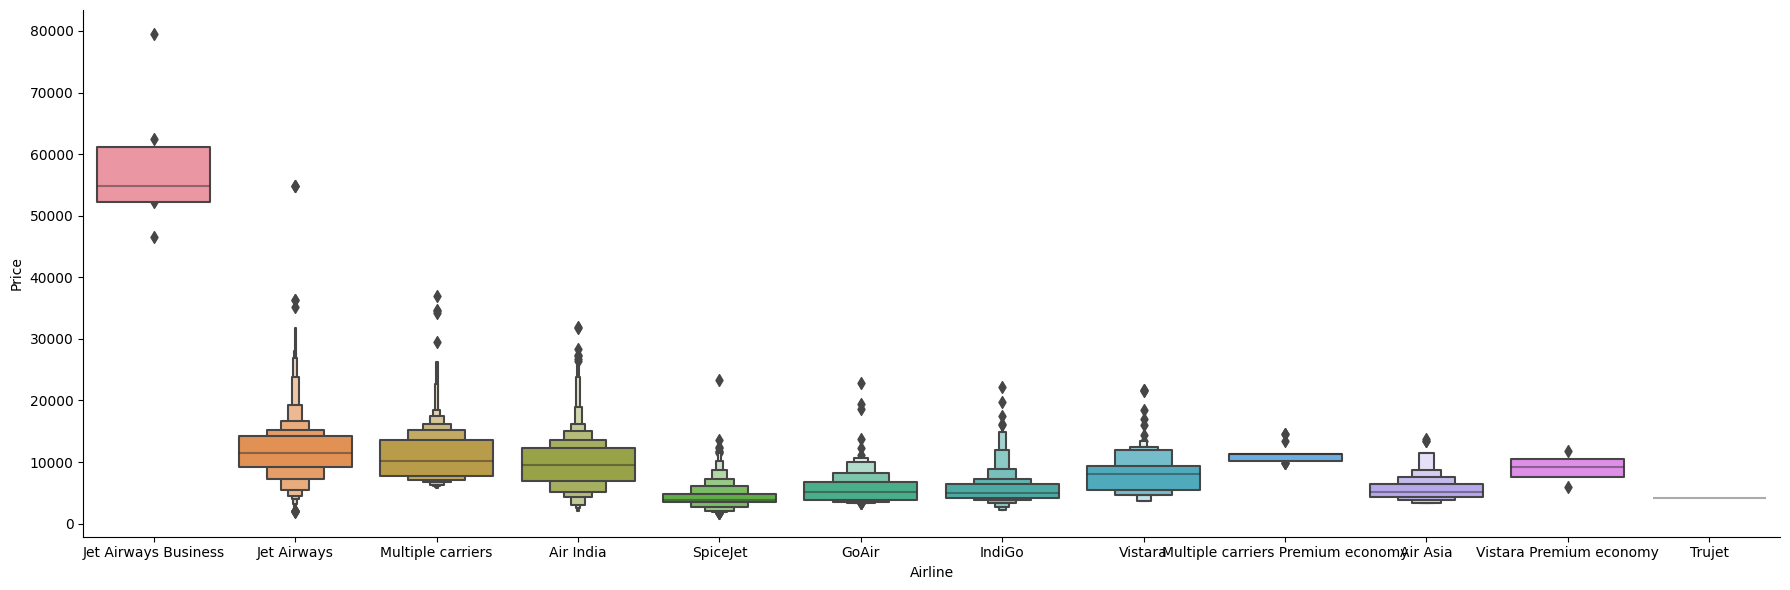

In [4]:
# Preprocessing Training Data
train_data.dropna(inplace = True)
train_data["Journey_day"] = pd.to_datetime(train_data["Date_of_Journey"], format="%d/%m/%Y").dt.day
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
train_data.drop(["Date_of_Journey"], axis=1, inplace=True)
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute
train_data.drop(["Dep_Time"], axis = 1, inplace = True)
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)
duration = list(train_data["Duration"])

for i in range(len(duration)):
    # checking if it conatins only hours or mins
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i]
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))
train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins
train_data.drop(["Duration"], axis = 1, inplace = True)
print(train_data["Airline"].value_counts())
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [5]:
# Encoding the training dataset
Airline = train_data[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)
Source = train_data[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)
train_data["Destination"].value_counts()
Destination = train_data[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)
train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)
print(data_train.head())

   Total_Stops  Price  Journey_day  Journey_month  Dep_hour  Dep_min  \
0            0   3897           24              3        22       20   
1            2   7662            1              5         5       50   
2            2  13882            9              6         9       25   
3            1   6218           12              5        18        5   
4            1  13302            1              3        16       50   

   Arrival_hour  Arrival_min  Duration_hours  Duration_mins  \
0             1           10               2             50   
1            13           15               7             25   
2             4           25              19              0   
3            23           30               5             25   
4            21           35               4             45   

   Airline_Air India  Airline_GoAir  Airline_IndiGo  Airline_Jet Airways  \
0                  0              0               1                    0   
1                  1              0 

In [7]:
# Preprocessing the test data and creating testing dataframe
test_data = pd.read_excel("./../test_dataset_kaggle.xlsx")
print(test_data.head())
print(test_data.info())
test_data.dropna(inplace = True)
test_data.isnull().sum()
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i]

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)
test_data["Airline"].value_counts()
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)
test_data["Source"].value_counts()
Source = pd.get_dummies(test_data["Source"], drop_first= True)
test_data["Destination"].value_counts()
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)
data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)
print(data_test.shape)
print(data_test.head())

             Airline Date_of_Journey    Source Destination            Route  \
0        Jet Airways       6/06/2019     Delhi      Cochin  DEL → BOM → COK   
1             IndiGo      12/05/2019   Kolkata    Banglore  CCU → MAA → BLR   
2        Jet Airways      21/05/2019     Delhi      Cochin  DEL → BOM → COK   
3  Multiple carriers      21/05/2019     Delhi      Cochin  DEL → BOM → COK   
4           Air Asia      24/06/2019  Banglore       Delhi        BLR → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops              Additional_Info  
0    17:30  04:25 07 Jun  10h 55m      1 stop                      No info  
1    06:20         10:20       4h      1 stop                      No info  
2    19:15  19:00 22 May  23h 45m      1 stop  In-flight meal not included  
3    08:00         21:00      13h      1 stop                      No info  
4    23:55  02:45 25 Jun   2h 50m    non-stop                      No info  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries,

In [8]:
# Taking all the coloumns excpet price
X = data_train.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
print(X.head())
y = data_train.iloc[:, 1]
print(y.head())


   Total_Stops  Journey_day  Journey_month  Dep_hour  Dep_min  Arrival_hour  \
0            0           24              3        22       20             1   
1            2            1              5         5       50            13   
2            2            9              6         9       25             4   
3            1           12              5        18        5            23   
4            1            1              3        16       50            21   

   Arrival_min  Duration_hours  Duration_mins  Airline_Air India  \
0           10               2             50                  0   
1           15               7             25                  1   
2           25              19              0                  0   
3           30               5             25                  0   
4           35               4             45                  0   

   Airline_GoAir  Airline_IndiGo  Airline_Jet Airways  \
0              0               1                    0   
1 

In [9]:
# Getting the train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
# Fitting the model into VotingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression

rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
lr = LinearRegression()

voting_regressor = VotingRegressor([('rf', rf), ('gb', gb), ('lr', lr)])
# Fitting the model
voting_regressor.fit(X_train, y_train)

# Predicting the values
y_pred = voting_regressor.predict(X_test)

# Calculating the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
accuracy = voting_regressor.score(X_test, y_test)
print("Accuracy: ", accuracy)

Mean Absolute Error: 1425.5316513211928
Accuracy:  0.8005499700691565


In [13]:
# Saving the model to a pickel file
import pickle

file = open('voting_regressor.pkl', 'wb')
pickle.dump(voting_regressor, file)

In [23]:
# Using the pickel file to get the trained model
model = open('voting_regressor.pkl','rb')
voting = pickle.load(model)

y_prediction = voting.predict(X_test)